# Feature Selection

The goal of this notebook is to perform the feature selection. There are three methods that will be used to perform the feature selection:
1. Inspection - The first step is to manually remove some of the features through human inspection. 
2. Random forest - The features will be ranked based on the importance score provided by the random forest classifier and the top $n$ features will be selected
3. Brute force - Train the ML models by using different number of features. The accuracy of each model with respect to the number of features will be recorded to select the most concise feature set.  

In [1]:
# import all necessary packages

# basic packages for data processing
import os       # to create directories and remove files
import pandas as pd
import numpy as np 
import random # import random package to specify the random seed

# modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# modules to interpret the training result
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# silent the warning from the sklearn library
import warnings
warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
random.seed(10)
np.random.seed(10)


Load the dataset. 

Since the LUFlow dataset is huge, only 5% of dataset will be used for feature selection

In [2]:
# load the dataset
luflow = pd.read_csv('Dataset/dataset_cleaned/LUFlow.csv')
luflow = luflow.sample(frac=0.05).reset_index(drop=True)
luflow.shape

(87974, 16)

## Step 1. Inspection

In this step, some of the features will be manually removed. This step is necessary as some features will affect the long term performance of the model despite having high correlation with the output variable. IP address, for example, is a feature that might be useful to detect intrusion in short term but may not be as useful in longer term. 

In the LUFlow dataset, there are several features that should be removed. First is the `src_ip` and the `dest_ip` columns, which represent source IP address and destination IP address respectively. 

Besides that there are two columns called `time_start` and `time_end`, which are time recorded using UNIX timestamp. These columns should be removed as it will keep increasing as the time pass and thus not providing meaningful information. However, the difference between `time_start` and `time_end` could provide useful information. In the dataset, there is also a column called `duration`, it should be checked if it represent the difference between `time_start` and `time_end`. 

In [3]:
luflow['time_between'] = luflow['time_end'] - luflow['time_start']

luflow[['time_start', 'time_end', 'time_between', 'duration']]

,time_start,time_end,time_between,duration
0,1593970963610084,1593970963610084,0,0.000000
1,1595303744019711,1595303744019711,0,0.000000
2,1595071437271669,1595071438106433,834764,0.834764
3,1593674270265568,1593674271008109,742541,0.742541
4,159527274486398,1595272752016373,1435745477529975,7.152393
...,...,...,...,...
87969,1594382446702303,1594382446714443,12140,0.012140
87970,1593664319741509,1593664319741585,76,0.000076
87971,1595061099373362,1595061100329039,955677,0.955677
87972,1594571979216475,1594571979216978,503,0.000503


From the table above, we can see that the `duration` represent the difference between `time_start` and `time_end`. 

### Drop the unwanted columns

In [4]:
luflow = luflow.drop(['src_ip', 'dest_ip', 'time_start', 'time_end', 'time_between'], axis=1)
luflow.head()

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,label,duration
0,0.00,0,517,50850.0,7.310200,1,0,6,9200.0,3779.3735,benign,0.000000
1,0.00,0,0,9200.0,0.000000,1,0,6,34772.0,0.0000,benign,0.000000
2,107.75,270,191,445.0,4.573646,6,6,6,56851.0,2108.4510,malicious,0.834764
3,101.50,270,191,445.0,4.571218,6,6,6,59398.0,2107.3313,malicious,0.742541
4,0.00,0,0,53.0,0.000000,4,0,6,54168.0,0.0000,benign,7.152393


## Step 2. Random forest feature selection

In this step, the features will be selected using the random forest algorithm. First, a random forest will be trained. After that, the features will be ranked according to the importance score provided by the random forest and the top $n$ features will be selected. 

In [5]:
# seperate the features and the output variables into two dataframe
luflow_X = luflow.drop('label', axis=1).copy()
luflow_y = luflow['label'].copy()

In [6]:
%%time

rfc = RandomForestClassifier()
rfc.fit(luflow_X, luflow_y)

Wall time: 6.21 s


RandomForestClassifier()

Top features: 
               importance score
feature                        
dest_port                 0.347
bytes_out                 0.165
total_entropy             0.126
src_port                  0.106
num_pkts_in               0.081
duration                  0.077
avg_ipt                   0.026
entropy                   0.023
bytes_in                  0.021
num_pkts_out              0.020
proto                     0.007


<AxesSubplot:xlabel='feature'>

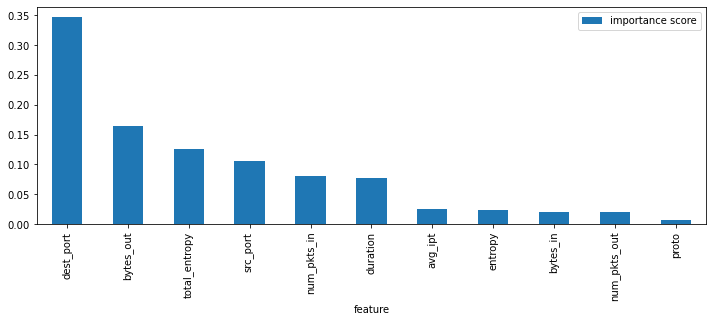

In [7]:
#extract the importance score
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': luflow_X.columns,
                             'importance score': score})
importance = importance.sort_values('importance score', ascending=False).set_index('feature')

print(f"Top features: \n{importance}")

plt.rcParams['figure.figsize'] = (12, 4)
importance.plot.bar()

In [8]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = 'Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [9]:
# save the ranking of the features in a CSV file
features = pd.Series(importance.index[:], dtype='str')
save_feature(features=features,
            dataset_name='LUFlow', 
            algorithm='RandomForestClassifier')

The features have been saved in Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv


## Step 3. Brute force

After selecting the features using random forest, the number of features will be further reduced using brute force. The method is quite simple, the ML models will be trained using different number of features. The feature set that can gives comparable accuracy with the least number of features will be the final feature set. 

 Started from the $1^{st}$ ranked feature, features will be added until all $n$ features are used. As the LUFlow dataset only contain a few number of features, the $n$ is equals to the total number of features. 

In [10]:
# define ML models without optimized hyperparameter
models = {
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500)
}

In [11]:
luflow_train_X, luflow_test_X, luflow_train_y, luflow_test_y = train_test_split(luflow_X, luflow_y, test_size=0.3)

In [12]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature}) ...")
    
    test_X = luflow_test_X[feature_set]
    train_X = luflow_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]
    
    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, luflow_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(luflow_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

Added feature 1 (dest_port) ...
Added feature 2 (bytes_out) ...
Added feature 3 (total_entropy) ...
Added feature 4 (src_port) ...
Added feature 5 (num_pkts_in) ...
Added feature 6 (duration) ...
Added feature 7 (avg_ipt) ...
Added feature 8 (entropy) ...
Added feature 9 (bytes_in) ...
Added feature 10 (num_pkts_out) ...
Added feature 11 (proto) ...


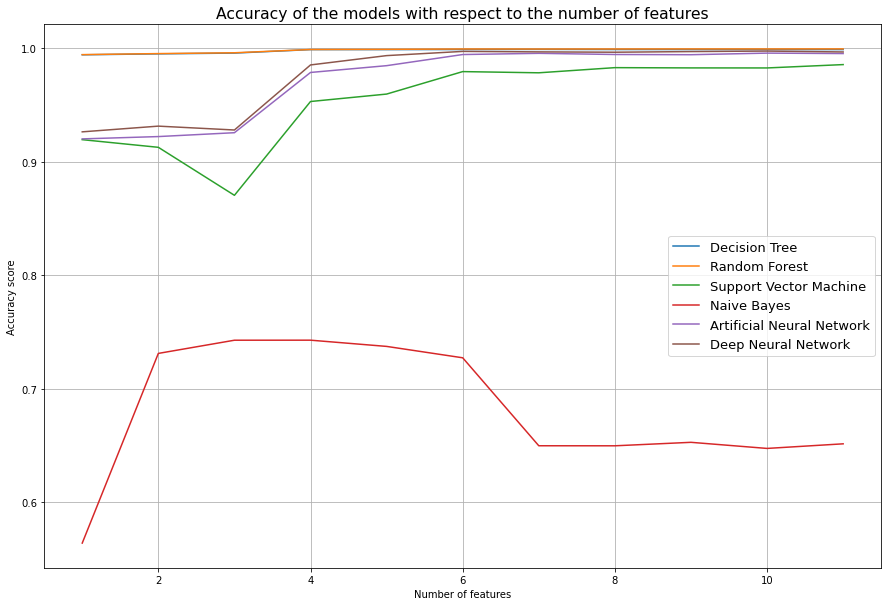

In [13]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()

From the chart above, we can see that the top $6$ features will give the best and most balanced accuracy. 